In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
seaborn.set_style('dark')
np.set_printoptions(precision=3)

%matplotlib inline

In [2]:
import sklearn
import sklearn.metrics
import sklearn.grid_search
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.preprocessing
import sklearn.pipeline
import pescador

In [3]:
import glob

In [4]:
def load_file(filename, n_pos=32, n_neg=32):
    
    data = np.load(filename)
    
    d = data['X'].shape[1]
    
    if n_pos is None:
        return data['X'], data['Y']
    
    
    positives = np.flatnonzero(data['Y'])
    negatives = np.flatnonzero(1-data['Y'])
    n_pos = min(n_pos, len(positives))
    n_neg = min(n_neg, len(negatives))
    
    X = np.empty((n_pos + n_neg, d), dtype=np.float32)
    Y = np.zeros((n_pos + n_neg), dtype=np.int32)
    
    if n_pos > 0:
        idx_pos = np.random.choice(positives, size=n_pos, replace=False)
    
        X[:n_pos] = np.take(data['X'], idx_pos, axis=0)
        Y[:n_pos] = 1
    
    if n_neg > 0:
        idx_neg = np.random.choice(negatives, size=n_neg, replace=False)
        X[n_pos:] = np.take(data['X'], idx_neg, axis=0)
    
    return X, Y

In [5]:
def load_batch(files, n_pos=32, n_neg=32):
    
    X = []
    Y = []
    
    for fn in files:
        _x, _y = load_file(fn, n_pos=n_pos, n_neg=n_neg)
        X.append(_x)
        Y.append(_y)
        
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    
    return X, Y

In [33]:
#files = sorted(glob.glob('../data/labeled_features/SALAMI_*.npz'))
files = sorted(glob.glob('../data/labeled_features/Isophonics_*.npz'))

In [34]:
filesplitter = sklearn.cross_validation.ShuffleSplit(len(files), n_iter=1, test_size=0.20, random_state=5)
_files = np.asarray(files)

In [35]:
for trainf, testf in filesplitter:
    
    print 'Loading training data...'
    X_train, Y_train = load_batch([_files[_] for _ in trainf],
                                 n_pos=128,
                                 n_neg=128)
    
    estimator = sklearn.linear_model.SGDClassifier(loss='log',
                                                   verbose=1)
    
    feature = sklearn.preprocessing.StandardScaler()
    
    _model = sklearn.grid_search.GridSearchCV(estimator,
                                             {'alpha': np.logspace(-3, 3, num=6, endpoint=False),
                                             'penalty': ['l1', 'l2', 'elasticnet']},
                                             n_jobs=3, verbose=1)
    
    model = sklearn.pipeline.Pipeline([('scaler', feature), ('predictor', _model)])
    
    model.fit(X_train, Y_train)
    
    print 'Loading testing data...'
    X_test, Y_test = load_batch([_files[_] for _ in testf],
                                n_pos=None,
                                n_neg=None)

Loading training data...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=3)]: Done   1 jobs       | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done  50 out of  54 | elapsed:   54.5s remaining:    4.4s
[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:   58.2s finished


-- Epoch 1
Norm: 0.13, NNZs: 924, Bias: -0.326320, T: 60074, Avg. loss: 0.588351-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 397.95, NNZs: 522, Bias: -7.063666, T: 40049, Avg. loss: 39.102715Norm: 383.99, NNZs: 459, Bias: -6.382068, T: 40049, Avg. loss: 33.459005Norm: 399.15, NNZs: 461, Bias: -3.913847, T: 40050, Avg. loss: 35.282288


Total training time: 0.53 seconds.
Total training time: 0.57 seconds.
Total training time: 0.54 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 397.61, NNZs: 114, Bias: -0.203736, T: 80098, Avg. loss: 20.531859Norm: 385.12, NNZs: 98, Bias: -0.591103, T: 80098, Avg. loss: 17.294420Norm: 400.31, NNZs: 85, Bias: -0.243423, T: 80100, Avg. loss: 18.242337


Total training time: 1.18 seconds.
Total training time: 1.21 seconds.
Total training time: 0.98 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 398.28, NNZs: 101, Bias: -0.348290, T: 120147, Avg. loss: 13.894926Norm: 385.74, NNZs: 86, Bias: -0.448722, T: 120147, Avg. loss: 11.729881Norm: 400.98, NNZs: 90, Bias: 

In [36]:
w = model.steps[1][1].best_estimator_.coef_[0]

In [50]:
w = w.reshape((-1, 84))

<matplotlib.colorbar.Colorbar instance at 0x7f2978c7c128>

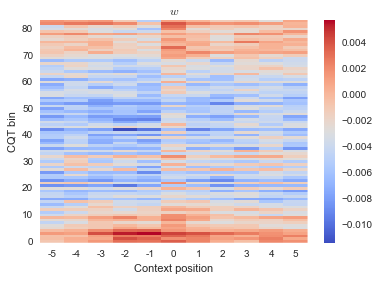

In [51]:
plt.imshow(w.T, aspect='auto', interpolation='none', cmap='coolwarm', origin='lower')
plt.ylabel('CQT bin')
plt.xlabel('Context position')
plt.title('$w$')
plt.xticks(np.arange(11), np.arange(-5, 6))
plt.colorbar()

In [39]:
print sklearn.metrics.classification_report(Y_train, model.predict(X_train))

             precision    recall  f1-score   support

          0       0.73      0.65      0.68     29595
          1       0.69      0.76      0.72     30479

avg / total       0.71      0.71      0.71     60074



In [40]:
sklearn.metrics.accuracy_score(Y_train, model.predict(X_train))

0.70614575357059628

In [41]:
Y_pred = [model.predict(xt) for xt in X_test]

In [42]:
Y_pred = np.concatenate(Y_pred, axis=0)

In [43]:
print sklearn.metrics.classification_report(Y_test, Y_pred)

             precision    recall  f1-score   support

          0       0.77      0.65      0.70     93032
          1       0.58      0.72      0.64     63943

avg / total       0.69      0.68      0.68    156975



In [44]:
sklearn.metrics.accuracy_score(Y_test, Y_pred)

0.67515846472368213

In [30]:
import cPickle as pickle

In [45]:
#pickle.dump({'model': model, 'dataset': 'salami'}, open('../data/similarity_model_salami.pickle', 'w'))
pickle.dump({'model': model, 'dataset': 'isophonics'}, open('../data/similarity_model_isophonics.pickle', 'w'))